# Hand-crafted features for GTZAN

> The goal of this notebook is to create several audio features descriptors for the GTZAN dataset, as proposed for many year as input for machine learning algorithms. We are going to use timbral texture based features and tempo based features for this. The main goal is to produce this features, classify and then compare with our proposed deep learning approach, using CNNs on the raw audio.

> This script is from https://github.com/Hguimaraes/gtzan.keras adapted to my case of 2 specific sub-genres

In [31]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew

In [32]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [33]:
# Set the seed
np.random.seed(42)

In [34]:
gtzan_dir = '../Data/songs/full_test_set/'

In [35]:
# Parameters
#song_samples = 22050*30
genres = {'black': 0, 'death': 1}

In [36]:
def get_features(y, sr, n_fft = 1024, hop_length = 512):
    # Features to concatenate in the final dictionary
    features = {'centroid': None, 'roloff': None, 'flux': None, 'rmse': None,
                'zcr': None, 'contrast': None, 'bandwidth': None, 'flatness': None}
    
    # Count silence
    if 0 < len(y):
        y_sound, _ = librosa.effects.trim(y, frame_length=n_fft, hop_length=hop_length)
    features['sample_silence'] = len(y) - len(y_sound)

    # Using librosa to calculate the features
    features['centroid'] = librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['roloff'] = librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['rmse'] = librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(y, sr=sr).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(y, n_fft=n_fft, hop_length=hop_length).ravel()
    
    # MFCC treatment
    mfcc = librosa.feature.mfcc(y, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
        
    # Get statistics from the vectors
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v)
            result['{}_skew'.format(k)] = skew(v)
        return result
    
    dict_agg_features = get_moments(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]
    
    return dict_agg_features

In [37]:
def read_process_songs(src_dir, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_features = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Append the result to the data structure
                features = get_features(signal, sr)
                features['genre'] = genres[x]
                arr_features.append(features)
    return arr_features

In [38]:
%%time

# Get list of dicts with features and convert to dataframe
features = read_process_songs(gtzan_dir, debug=True)

Reading file: ../Data/songs/full_test_set/black/01 - Alsvartr (The Oath).flac
Reading file: ../Data/songs/full_test_set/black/01 - Curse You All Men!.flac
Reading file: ../Data/songs/full_test_set/black/01 - I Am the Black Wizards.flac
Reading file: ../Data/songs/full_test_set/black/01 - The Loss and Curse of Reverence.flac


C:\Users\user\anaconda3\lib\site-packages\librosa\core\audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Reading file: ../Data/songs/full_test_set/black/01. Freezing Moon - Mayhem.mp3
Reading file: ../Data/songs/full_test_set/black/01. Funeral Fog - Mayhem.mp3
Reading file: ../Data/songs/full_test_set/black/02 - Ancient Queen.flac
Reading file: ../Data/songs/full_test_set/black/02 - Decrystallizing Reason.flac
Reading file: ../Data/songs/full_test_set/black/02 - In Longing Spirit.flac
Reading file: ../Data/songs/full_test_set/black/02 - Into The Infinity Of Thoughts.flac
Reading file: ../Data/songs/full_test_set/black/02 - Wrath of the Tyrant.flac
Reading file: ../Data/songs/full_test_set/black/02 - Ye Entrancemperium.flac
Reading file: ../Data/songs/full_test_set/black/02. Freezing Moon - Mayhem.mp3
Reading file: ../Data/songs/full_test_set/black/02. I Am Thy Labyrinth - Mayhem.mp3
Reading file: ../Data/songs/full_test_set/black/02. Pagan Fears - Mayhem.mp3
Reading file: ../Data/songs/full_test_set/black/03 - An Elegy Of Icaros.flac
Reading file: ../Data/songs/full_test_set/black/03 - My

Reading file: ../Data/songs/full_test_set/death/(06)_[Death]_Reign_Of_Terror_(Back_From_The_Dead_Demo).flac
Reading file: ../Data/songs/full_test_set/death/(06)_[Mantas]_Legion_Of_Doom.flac
Reading file: ../Data/songs/full_test_set/death/(06)_[Mantas]_Mantas_-_Take_1.flac
Reading file: ../Data/songs/full_test_set/death/(06)_[Slaughter]_Parisites.flac
Reading file: ../Data/songs/full_test_set/death/(07)_[Death]_Baptized_In_Blood.flac
Reading file: ../Data/songs/full_test_set/death/(07)_[Death]_Beyond_The_Unholy_Grave_(Back_From_The_Dead_Demo).flac
Reading file: ../Data/songs/full_test_set/death/(07)_[Death]_Reign_Of_Death_(Back_From_The_Dead_Demo_1986).flac
Reading file: ../Data/songs/full_test_set/death/(07)_[Death]_Summon_To_Die_(Reign_Of_Terror_Demo).flac
Reading file: ../Data/songs/full_test_set/death/(07)_[Mantas]_Mantas_-_Take_2.flac
Reading file: ../Data/songs/full_test_set/death/(07)_[Mantas]_Power_Of_Darkness.flac
Reading file: ../Data/songs/full_test_set/death/(07)_[Slaughter]

Reading file: ../Data/songs/full_test_set/death/02 - Unholy Blasphemies.mp3
Reading file: ../Data/songs/full_test_set/death/02 Evil Warriors.mp3
Reading file: ../Data/songs/full_test_set/death/02 my belief.mp3
Reading file: ../Data/songs/full_test_set/death/02 Swing of the Axe.Mp3
Reading file: ../Data/songs/full_test_set/death/02. Before The Penance.mp3
Reading file: ../Data/songs/full_test_set/death/02. Delirical Life.mp3
Reading file: ../Data/songs/full_test_set/death/02. Godly Beings.mp3
Reading file: ../Data/songs/full_test_set/death/02. Parricide.mp3
Reading file: ../Data/songs/full_test_set/death/02. The Process Of Suffocation.mp3
Reading file: ../Data/songs/full_test_set/death/03 - Abominations.mp3
Reading file: ../Data/songs/full_test_set/death/03 - Blasphemy Of The Holy Ghost.mp3
Reading file: ../Data/songs/full_test_set/death/03 - March To Die.mp3
Reading file: ../Data/songs/full_test_set/death/03 - Possessed - Evil Warriors (Demo 84).mp3
Reading file: ../Data/songs/full_tes

In [39]:
df_features = pd.DataFrame(features)

In [40]:
df_features.shape

(291, 134)

In [41]:
df_features.head()

,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,roloff_max,roloff_min,roloff_mean,roloff_std,...,mfcc_11_kurtosis,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo,genre
0,5366.555252,224.975709,1680.340574,709.694408,1.692524,0.286574,9517.675781,322.998047,3551.075060,1585.882762,...,0.331983,-0.109051,31.156044,-42.992348,-5.029020,8.442566,0.331698,-0.061190,135.999178,0
1,5073.259902,7.177735,3003.446944,357.972377,8.647255,-1.440324,8613.281250,21.533203,5670.178501,655.297271,...,0.171707,0.009480,21.646343,-33.964592,-2.576588,5.945803,0.303430,-0.086397,123.046875,0
2,4332.286096,266.467565,2832.194658,405.332380,3.188325,-1.024099,8441.015625,43.066406,6050.883372,850.099320,...,0.003018,0.024411,20.567032,-32.945972,-11.351251,6.188563,0.525876,0.248399,123.046875,0
3,4026.014791,0.000000,2311.272187,379.290955,13.044327,-2.268059,8613.281250,0.000000,4520.091520,792.259824,...,0.351085,-0.281689,20.905645,-29.985462,-5.122252,6.252759,0.002494,0.016714,117.453835,0
4,5154.624935,0.000000,2210.144133,377.419962,5.809504,-0.581749,9259.277344,0.000000,4251.629390,698.090999,...,0.446954,0.181946,17.603210,-36.698788,-12.576807,6.459480,0.167415,0.255703,123.046875,0


In [42]:
df_features.to_csv('../data/full_test_set_features.csv', index=False)

In [43]:
X = df_features.drop(['genre'], axis=1).values
y = df_features['genre'].values

## Visualization

> Linear (and nonlinear) dimensionality reduction of the GTZAN features for visualization purposes

In [44]:
# Standartize the dataset
scale = StandardScaler()
x_scaled = scale.fit_transform(X)

In [45]:
# Use PCA only for visualization
pca = PCA(n_components=35, whiten=True)
x_pca = pca.fit_transform(x_scaled)
print("cumulative explained variance ratio = {:.4f}".format(np.sum(pca.explained_variance_ratio_)))

cumulative explained variance ratio = 0.8823


In [68]:
# Use LDA only for visualization
lda = LDA()
x_lda = lda.fit_transform(x_scaled, y)

In [47]:
# Using tsne
tsne = TSNE(n_components=2, verbose=1, learning_rate=250)
x_tsne = tsne.fit_transform(x_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 291 samples in 0.010s...
[t-SNE] Computed neighbors for 291 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 291 / 291
[t-SNE] Mean sigma: 4.918936
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.163414
[t-SNE] KL divergence after 1000 iterations: 0.495649


(291, 35)
(291, 1)


IndexError: index 1 is out of bounds for axis 1 with size 1

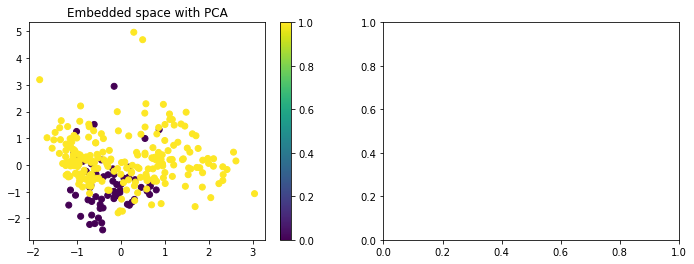

In [50]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
print(x_pca.shape)
plt.scatter(x_pca[:,0], x_pca[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with PCA")

plt.subplot(132)
print(x_lda.shape)
plt.scatter(x_lda[:,0], x_lda[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with LDA")

plt.subplot(133)
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with TSNE")
plt.show()

<AxesSubplot:>

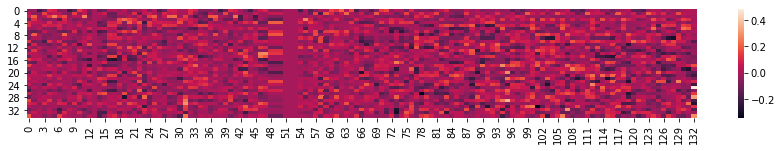

In [88]:
# idea from https://github.com/rodriguezda/PCA/blob/master/pca%20pipeline.ipynb
import seaborn as sns
df = pd.DataFrame(X)
df_component = pd.DataFrame(pca.components_, columns = df.columns)
plt.figure(figsize=(15,2))
sns.heatmap(df_component)

0      62
1      63
2      11
3      55
4      20
5      88
6     130
7      21
8       7
9      77
10    120
11     93
12     20
13     88
14     47
15     46
16    127
17     73
18     94
19    108
20     95
21    112
22     95
23    129
24    112
25    132
26     95
27     15
28    132
29     95
30     31
31    100
32    107
33     75
34    132
dtype: int64


<AxesSubplot:>

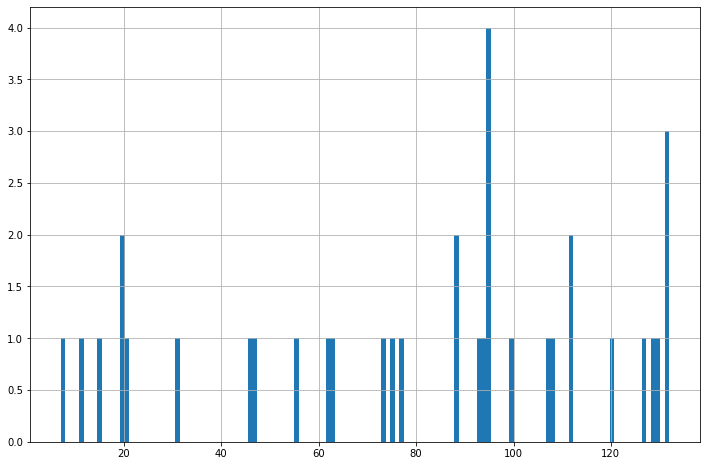

In [116]:
max_vals = df_component.idxmax(1)
print(max_vals)
max_vals.hist(bins=133, figsize=(12,8))

## Classical Machine Learning

In [51]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

### Logistic Regression

In [53]:
params = {
    "cls__penalty": ["l1", "l2"], # penalty norms
    "cls__C": [0.5, 1, 2, 5], # regularisation - smaller is stronger
    "cls__max_iter": [500] # maximum number of iterations
}

pipe_lr = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', LogisticRegression())
])

grid_lr = GridSearchCV(pipe_lr, params, scoring='accuracy', n_jobs=6, cv=5)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', LogisticRegression())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1, 2, 5], 'cls__max_iter': [500],
                         'cls__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [54]:
preds = grid_lr.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_lr.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.9589
best score on test set (accuracy) = 0.9315


### ElasticNet

In [55]:
params = {
    "cls__loss": ['log'],
    "cls__penalty": ["elasticnet"],
    "cls__l1_ratio": [0.15, 0.25, 0.5, 0.75],
}

pipe_en = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SGDClassifier())
])

grid_en = GridSearchCV(pipe_en, params, scoring='accuracy', n_jobs=6, cv=5)
grid_en.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', SGDClassifier())]),
             n_jobs=6,
             param_grid={'cls__l1_ratio': [0.15, 0.25, 0.5, 0.75],
                         'cls__loss': ['log'], 'cls__penalty': ['elasticnet']},
             scoring='accuracy')

In [56]:
preds = grid_en.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_en.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.9632
best score on test set (accuracy) = 0.9315


### Decision Tree

In [57]:
params = {
    "cls__criterion": ["gini", "entropy"],
    "cls__splitter": ["best", "random"],
}

pipe_cart = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', DecisionTreeClassifier())
])

grid_cart = GridSearchCV(pipe_cart, params, scoring='accuracy', n_jobs=6, cv=5)
grid_cart.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', DecisionTreeClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__splitter': ['best', 'random']},
             scoring='accuracy')

In [58]:
preds = grid_cart.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_cart.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.9224
best score on test set (accuracy) = 0.8493


### Random Forest

In [59]:
params = {
    "cls__n_estimators": [100, 250, 500, 1000],
    "cls__criterion": ["gini", "entropy"],
    "cls__max_depth": [5, 7, None]
}

pipe_rf = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', RandomForestClassifier())
])

grid_rf = GridSearchCV(pipe_rf, params, scoring='accuracy', n_jobs=6, cv=5)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', RandomForestClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__max_depth': [5, 7, None],
                         'cls__n_estimators': [100, 250, 500, 1000]},
             scoring='accuracy')

In [60]:
preds = grid_rf.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_rf.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.9362
best score on test set (accuracy) = 0.8493


### SVM

In [61]:
params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5)
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', SVC())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1, 2, 5],
                         'cls__kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='accuracy')

In [62]:
preds = grid_svm.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.9681
best score on test set (accuracy) = 0.9041


## Results and save the model

In [63]:
cm = confusion_matrix(y_test, preds)
classes = ['black', 'death']

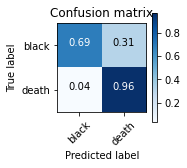

In [64]:
plt.figure(figsize=(2,2))
plot_confusion_matrix(cm, classes, normalize=True)

In [65]:
import joblib

In [66]:
joblib.dump(grid_svm, "../Models/pipe_svm.joblib")

['../Models/pipe_svm.joblib']